# Physics-informed

Outputs of operators are functions, so we are able to compute derivatives with
respect to evaluation coordinates (as in PINNs).
Therefore, it is possible to impose physical laws within
the loss function that is used to train an operator!

This example demonstrates the training of a physics-informed neural operator.

## Setup

In [1]:
import torch
import matplotlib.pyplot as plt
from continuiti.operators import DeepONet
from continuiti.pde import Grad, PhysicsInformedLoss
from continuiti.data import OperatorDataset
from continuiti.trainer import Trainer

In [2]:
torch.manual_seed(0)
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)
plt.rcParams["legend.framealpha"] = 0.0


## Problem Statement

Let's assume we want to learn the solution operator $G: u \mapsto v$ of the
differential equation

$$
\frac{\partial v}{\partial x} = u.
$$

In this example, the solution operator $G$ is the integration
operator

$$
G(u) = \int u~dx \ + c,
$$

where we choose $c$ such that $\int G(u) = 0$. We can learn this
operator by only prescribing the differential equation in
the loss function (aka physics-informed)!

Let's choose a set of polynomials with random coefficients as input functions
and visualize them.

In [3]:
# Input functions are polynomials to degree p
p = 2
poly = lambda a, x: sum(a[i] * x ** i for i in range(p+1))

# Generate random coefficients for N polynomials
num_functions = 4
a = torch.randn(num_functions, p+1)

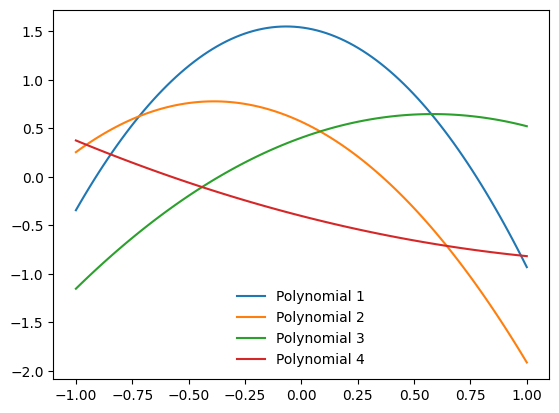

In [4]:
x = torch.linspace(-1, 1, 100)
for i in range(num_functions):
    plt.plot(x, poly(a[i], x), label=f"Polynomial {i+1}")
plt.legend()
plt.show()

## Dataset

An operator dataset contains the input functions (evaluated at a
random set of sensor positions) and a set of evaluation coordinates, but
we do not need to specify any labels as we will use a physics-informed loss
function instead.

In [5]:
num_sensors = 32
x = (2 * torch.rand(num_sensors, 1) - 1).reshape(1, num_sensors)
u = torch.stack([poly(a[i], x) for i in range(num_functions)])

# Evaluation positions (that require grad for physics-informed loss)
y = x.clone()
y.requires_grad = True

# Reshape inputs for OperatorDataset
x = x.repeat(num_functions, 1, 1)
u = u.reshape(num_functions, 1, num_sensors)
y = y.repeat(num_functions, 1, 1)
v = torch.zeros(num_functions, 1, num_sensors) # labels won't be used

dataset = OperatorDataset(x, u, y, v)

## Neural Operator

In this example, we use a DeepONet architecture with the shapes inferred from the dataset.

In [6]:
operator = DeepONet(shapes=dataset.shapes)

## Physics-informed loss

Now, we define a physics-informed loss function to train the operator.
We specify the (partial) differential equation as a function `pde` that maps the
operator input (`x`, `u`, `y`) and its prediction (`v`) to the PDE loss.
The `Grad()` function uses autograd under the hood and computes the gradient of
the prediction `v` with respect to the evaluation coordinates `y`.


In [7]:
mse = torch.nn.MSELoss()

def pde(_, u, y, v):
    v_y = Grad()(y, v)
    return mse(v_y, u)

## Training

Putting the PDE loss into a `PhysicsInformedLoss` object, we can
pass it to the trainer and train the neural operator.

In [8]:
loss_fn = PhysicsInformedLoss(pde)

Trainer(operator, loss_fn=loss_fn).fit(dataset, tol=1e-4)

Parameters: 5872  Device: mps
Epoch 326/1000  Step 1/1  [====================]  8ms/step  ETA 0:05min - loss/train = 9.9738e-05  - stopping criterion met



## Evaluation

The trained operator can be evaluated at arbitrary positions, so let's plot the
predictions (at a finer resolution) along with the (exact) target function!

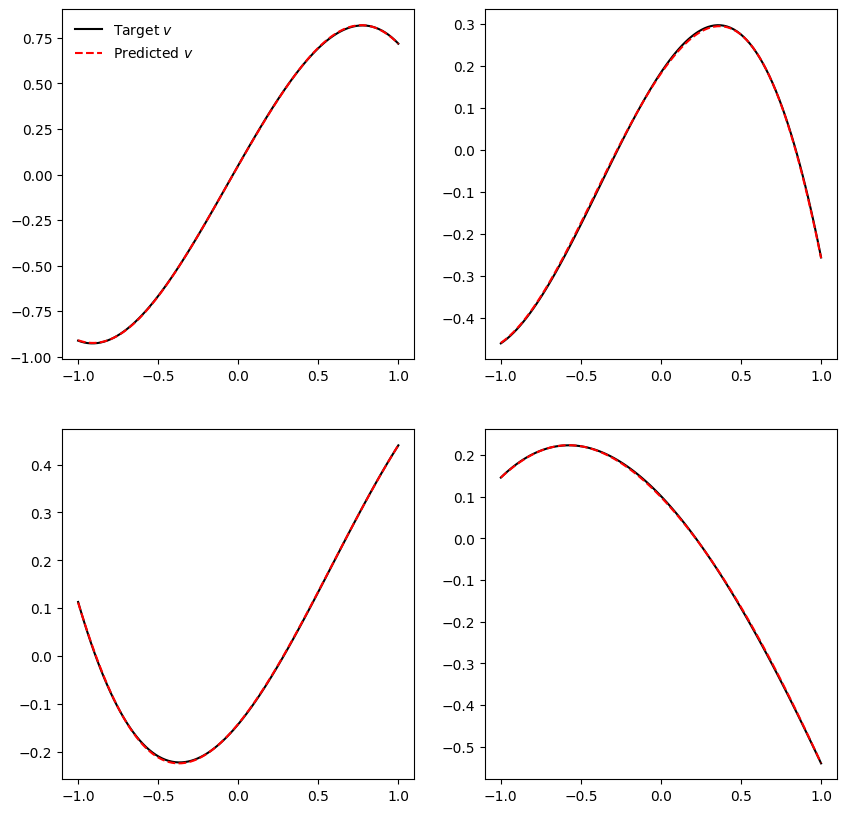

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

y = torch.linspace(-1, 1, 100).reshape(1, -1)

# Exact integral
integral = lambda a, x: sum(a[i] / (i+1) * x ** (i+1) for i in range(p+1))

# Call operator for polynomials
v_exact = torch.stack([integral(a[i], y) for i in range(num_functions)])

y = y.unsqueeze(0).repeat(num_functions, 1, 1)
v_pred = operator(x, u, y)

# Unify integral to zero mean
v_pred -= v_pred.mean(dim=-1, keepdim=True)
v_exact -= v_exact.mean(dim=-1, keepdim=True)

# Plot functions
v_pred = v_pred.detach()
y = y.detach()

for i in range(num_functions):
    axs[i // 2][i % 2].plot(y[i].flatten(), v_exact[i].flatten(), "k-", label="Target $v$")
    axs[i // 2][i % 2].plot(y[i].flatten(), v_pred[i].flatten(), "r--", label="Predicted $v$")
axs[0][0].legend()
plt.show()

As you can see, the physics-informed neural operator is able to approximate the
integration operator quite well (for our training samples).